In [1]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import cv2
import os
import shutil
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
import random
import torchsummary
from PIL import Image
from pathlib import Path
import pandas as pd
import numpy as np


# Handling images
from PIL import Image
import matplotlib.pyplot as plt

# Handling paths

import time

# Pytorch essentials
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import models
from torchvision.datasets import ImageFolder
import torchsummary



# Pytorch essentials for datasets.
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Pytorch way of data augmentation.
import torchvision
from torchvision import datasets, models, transforms, utils
from torchvision.transforms import v2

import cv2
import os
from glob import glob
from tqdm import tqdm
import shutil
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
df = pd.read_csv('/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv')



In [2]:
class MyCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = self._make_block(3, 8, 3)
        self.conv2 = self._make_block(8, 16, 3)
        self.conv3 = self._make_block(16, 32, 3)
        self.conv4 = self._make_block(32, 64, 3)
        self.conv5 = self._make_block(64, 64, 3)

        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=3136, out_features=512),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512, out_features=128),
            nn.ReLU()
        )
        self.fc3 = nn.Linear(in_features=128, out_features=num_classes)

    def _make_block(self, in_channels, out_channels, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same"),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding="same"),
            nn.BatchNorm2d(num_features=out_channels),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [3]:
class MyRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_size=256, num_layers=2, num_classes=10):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        
        self.rnn1 = self._make_rnn_block(embedding_dim, hidden_size, num_layers)
        self.rnn2 = self._make_rnn_block(hidden_size, hidden_size, num_layers)
        self.rnn3 = self._make_rnn_block(hidden_size, hidden_size, num_layers)
        
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(hidden_size, 128),
            nn.ReLU()
        )
        
        self.fc2 = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.fc3 = nn.Linear(64, num_classes)
        
    def _make_rnn_block(self, input_size, hidden_size, num_layers):
        return nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=0.3)
    
    def forward(self, x):
        x = self.embedding(x)  
        x, _ = self.rnn1(x)  
        x, _ = self.rnn2(x)  
        x, _ = self.rnn3(x)  
        x = x[:, -1, :]    
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [4]:
df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [5]:
df = df.loc[:, ~df.columns.str.contains('Unnamed: 0')]
df.head(7)

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
5,IM-0117-0001.jpeg,Normal,TRAIN,NaN,NaN
6,IM-0115-0001.jpeg,Normal,TRAIN,NaN,NaN


(5286, 624)

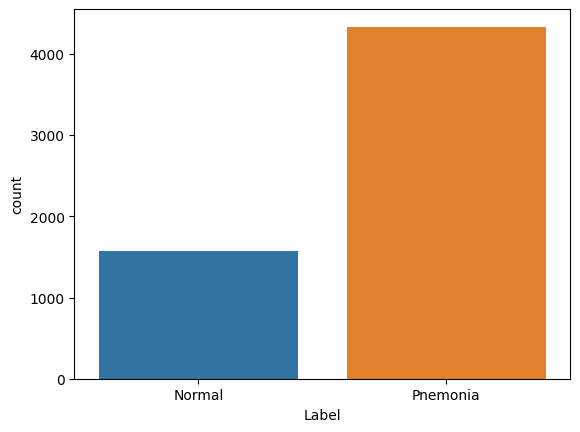

In [6]:
sns.countplot(x = df['Label'])
len(df[df['Dataset_type']=='TRAIN']),len(df[df['Dataset_type']=='TEST'])

In [7]:
data_path = Path('/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset')

training_folder_path = Path('/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train')

testing_folder_path = Path('/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test')

In [8]:
for dirpath, dirnames, filenames in os.walk(data_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset'.
There are 0 directories and 624 images in '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'.
There are 0 directories and 5309 images in '/kaggle/input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'.


In [9]:
img_path_list = list(data_path.glob('*/*.jpeg'))
sample_size = 20
ran_img = random.sample(img_path_list, sample_size)
filenames = [path.name for path in ran_img]

In [10]:
filenames

['person266_bacteria_1240.jpeg',
 'person409_virus_816.jpeg',
 'NORMAL2-IM-0309-0001.jpeg',
 'person1417_bacteria_3635.jpeg',
 'NORMAL2-IM-1256-0001.jpeg',
 'person811_virus_1447.jpeg',
 'person1636_bacteria_4337.jpeg',
 'person23_bacteria_81.jpeg',
 'person1665_virus_2878.jpeg',
 'person1484_virus_2576.jpeg',
 'person836_bacteria_2752.jpeg',
 'NORMAL2-IM-0468-0001.jpeg',
 'NORMAL2-IM-0995-0001-0002.jpeg',
 'person1908_bacteria_4811.jpeg',
 'person1857_bacteria_4729.jpeg',
 'person1146_bacteria_3091.jpeg',
 'NORMAL2-IM-0041-0001.jpeg',
 'IM-0500-0001.jpeg',
 'person1405_bacteria_3571.jpeg',
 'NORMAL2-IM-0837-0001.jpeg']

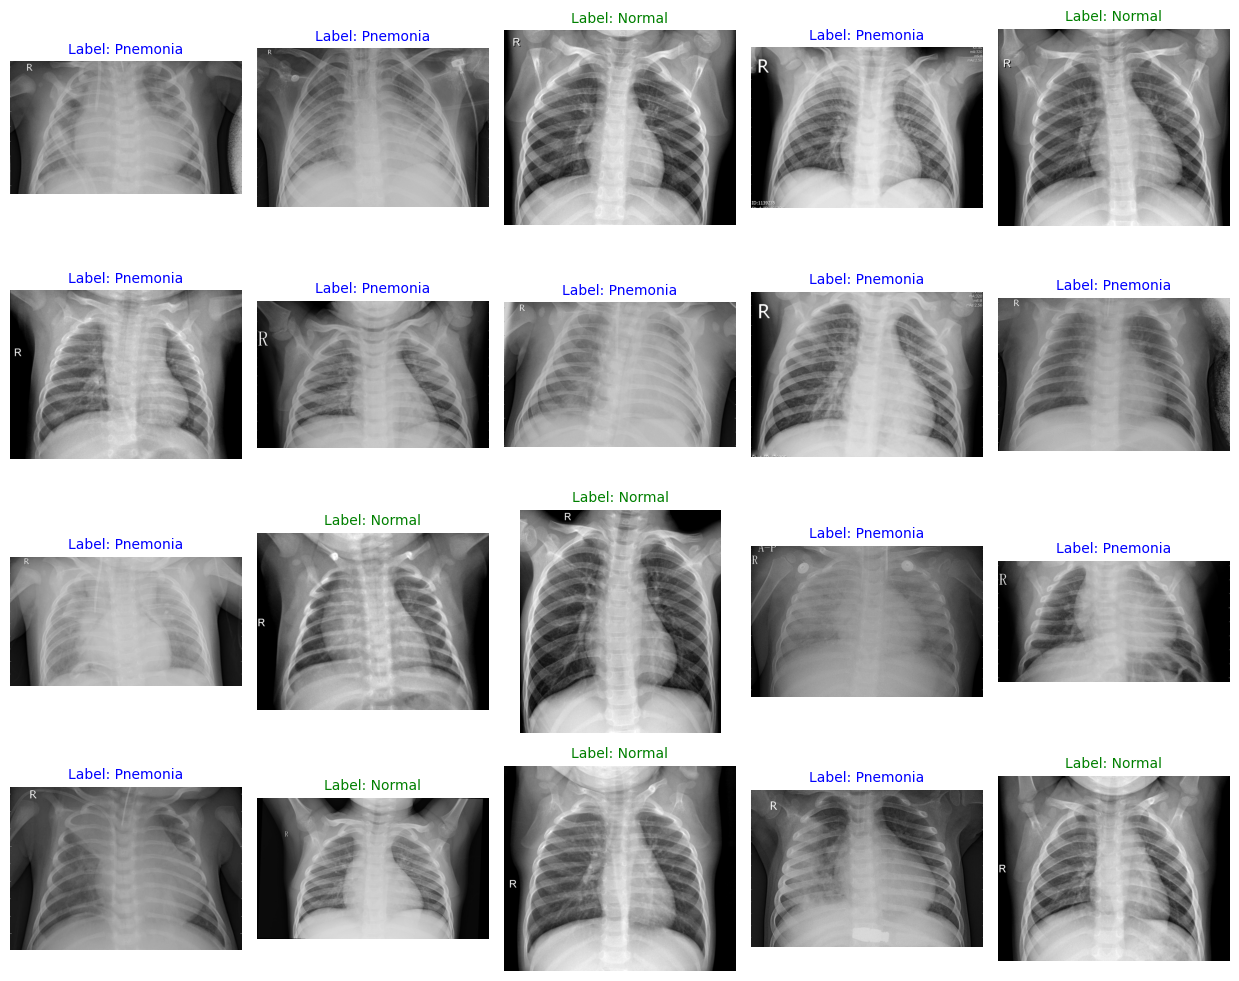

In [11]:
img_filenames = [img_path.name for img_path in ran_img]
labels = df[df["X_ray_image_name"].isin(img_filenames)][["X_ray_image_name", "Label"]].set_index("X_ray_image_name").to_dict()["Label"]

# Determine grid size (rows, cols)
cols = min(5, sample_size)  # Max 5 images per row
rows = (sample_size + cols - 1) // cols  # Ensure enough rows

# Create plotting figure
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2.5, rows * 2.5))

# Flatten axes for iteration (handles cases where grid has fewer elements)
axes = axes.flatten() if sample_size > 1 else [axes]

# Coloring
label_colors = {"Pneumonia": "red", "Normal": "green"}  

# Plot images
for ax, img_path in zip(axes, ran_img):
    img = plt.imread(img_path)
    label = labels.get(img_path.name, "Unknown")
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Label: {label}", fontsize=10, color=label_colors.get(label, "blue"))
    ax.axis("off")

# Hide any unused subplots
for ax in axes[len(ran_img):]:
    ax.axis("off")

plt.tight_layout()
plt.show()

In [12]:
class ChestXRayDataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None,dataset_type="train"):
        """
        Args:
            img_dir (str): Path to the directory containing images.
            csv_path (str): Path to the CSV file with labels.
            transform (torchvision.transforms): Image transformations.
        """
        # Load the CSV file
        self.df = pd.read_csv(csv_path)
        self.df = self.df[self.df["Dataset_type"] == dataset_type]
        # Store image directory path
        self.img_dir = img_dir

        # Image transformations
        self.transform = transform

    def __len__(self):
      return len(self.df)

    def __getitem__(self,idx):
        img_name = self.df.iloc[idx]["X_ray_image_name"]
        label = self.df.iloc[idx]["Label"]

        img_path = self.img_dir / img_name
        image = Image.open(img_path).convert("RGB")

        label_dict = {"Normal": 0, "Pnemonia": 1}
        label = label_dict.get(label, -1)

        if self.transform:
            image = self.transform(image)

        # image = Image.open(self.images[idx]).convert("RGB")
        # if self.transform:
        #     image = self.transform(image)
        # label = self.labels[idx]
        return image, label


In [13]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(size=(224, 224), antialias=True),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
])

In [14]:
train_dataset  = ChestXRayDataset(img_dir=training_folder_path,
                           csv_path="/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv",
                           transform=train_transforms,dataset_type="TRAIN")

test_dataset  = ChestXRayDataset(img_dir=testing_folder_path,
                           csv_path="/kaggle/input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv",
                           transform=test_transforms,dataset_type="TEST")

In [15]:
print([df.iloc[i]["X_ray_image_name"] for i in range(5)])

['IM-0128-0001.jpeg', 'IM-0127-0001.jpeg', 'IM-0125-0001.jpeg', 'IM-0122-0001.jpeg', 'IM-0119-0001.jpeg']


In [16]:
train_dataset[2]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 0)

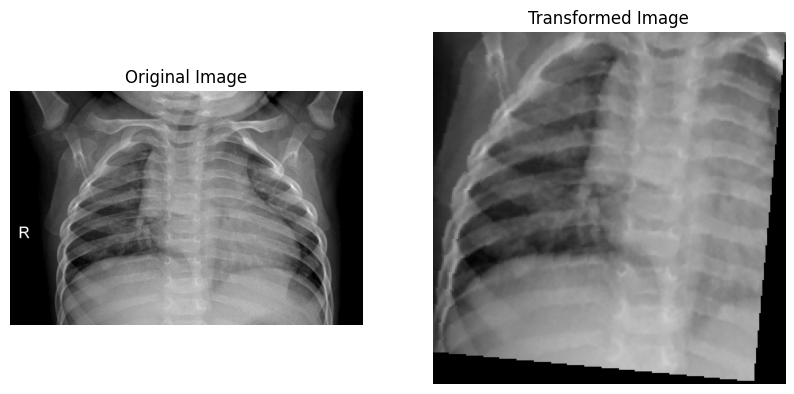

In [17]:
idx = 0
img_name = train_dataset.df.iloc[idx]["X_ray_image_name"]
img_path = train_dataset.img_dir / img_name

# Load the original image
original_image = Image.open(img_path).convert("RGB")

# Apply transformation
transformed_image = train_transforms(original_image)

# Convert transformed image back to numpy for visualization
transformed_image_np = transformed_image.permute(1, 2, 0).numpy()  # Convert CHW -> HWC

# Plot original and transformed images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original Image
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Transformed Image
axes[1].imshow(transformed_image_np)
axes[1].set_title("Transformed Image")
axes[1].axis("off")

plt.show()

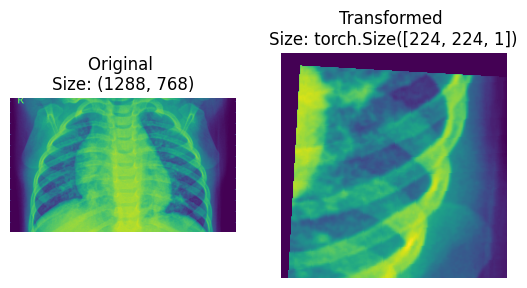

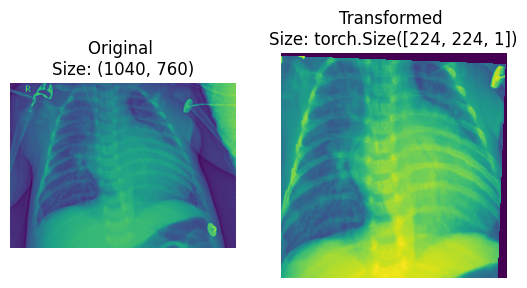

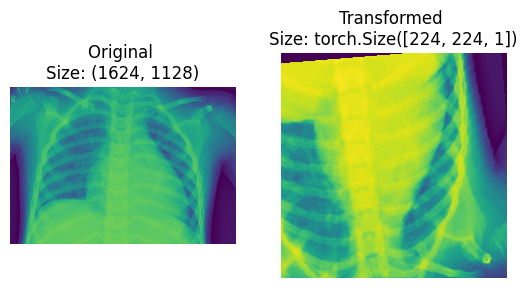

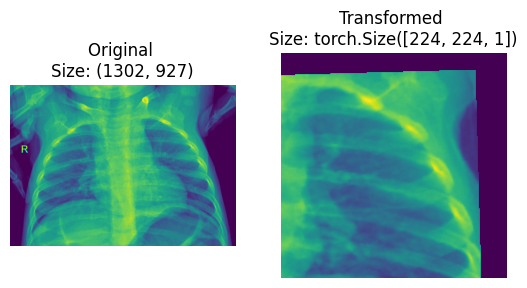

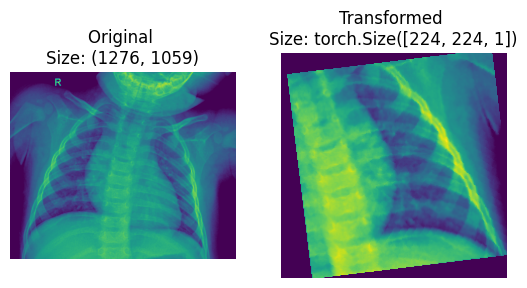

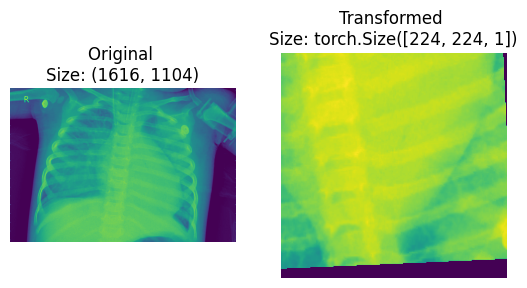

In [18]:
random_image_paths = random.sample(img_path_list, k=6)
for image_path in random_image_paths:
    with Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        transformed_image = train_transforms(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

In [19]:
BATCH_SIZE = 16
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True,
    num_workers=4,
    drop_last=True,
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True,
)

In [20]:
model = MyCNN(num_classes=3)
model(torch.randn((16,3,224,224))).shape

torch.Size([16, 3])

In [21]:
def train(dataloader, model, loss_fn, optimizer, lr_scheduler):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    for (data_,target_) in dataloader:
        target_ = target_.type(torch.LongTensor)
        data_, target_ = data_.to(device), target_.to(device)

        # First we'll clean the cache of optimizer
        optimizer.zero_grad()

        # Forward propagation
        outputs = model(data_)

        # Computing loss
        loss = criterion(outputs,target_)

        # Backward propagation
        loss.backward()

        # Optimizing model
        optimizer.step()

        # Computing statistics.
        epoch_loss = epoch_loss + loss.item()
        _,pred = torch.max(outputs,dim=1)
        epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    lr_scheduler.step()
    return epoch_correct/size, epoch_loss/num_batches

In [22]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset) # number of samples
    num_batches = len(dataloader) # batches per epoch
    epoch_loss = 0.0
    epoch_correct = 0
    with torch.no_grad():
        # This will disable backward propagation
        model.eval()
        for (data_,target_) in dataloader:
            target_ = target_.type(torch.LongTensor)
            data_, target_ = data_.to(device), target_.to(device)

            # Forward propagation
            outputs = model(data_)

            # Computing loss
            loss = criterion(outputs,target_)
            # Computing statistics.
            epoch_loss = epoch_loss + loss.item()
            _,pred = torch.max(outputs,dim=1)
            epoch_correct = epoch_correct + torch.sum(pred == target_).item()
    return  epoch_correct/size, epoch_loss/num_batches

In [23]:
device = torch.device("cpu")
EPOCHS = 20

logs = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

criterion = nn.CrossEntropyLoss()

# Optimizer setup
learning_rate = 0.0001
weight_decay = 0.1
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
lr_milestones = [7, 14, 21, 28, 35]
multi_step_lr_scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=lr_milestones, gamma=0.1)

# Early stopping parameters
patience = 5
counter = 0
best_loss = np.inf

for epoch in tqdm(range(EPOCHS)):
    train_acc, train_loss = train(train_loader, model, criterion, optimizer, multi_step_lr_scheduler)
    val_acc, val_loss = test(test_loader, model, criterion)

    print(f'EPOCH: {epoch} '
          f'train_loss: {train_loss:.4f}, train_acc: {train_acc:.3f} '
          f'val_loss: {val_loss:.4f}, val_acc: {val_acc:.3f} '
          f'Learning Rate: {optimizer.param_groups[0]["lr"]}')

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    torch.save(model.state_dict(), "last.pth")
    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(model.state_dict(), "best.pth")
    else:
        counter += 1

    if counter >= patience:
        print("Early stop!")
        break

  5%|▌         | 1/20 [03:23<1:04:33, 203.89s/it]

EPOCH: 0 train_loss: 0.4542, train_acc: 0.797 val_loss: 0.5354, val_acc: 0.712 Learning Rate: 0.0001


 10%|█         | 2/20 [06:53<1:02:11, 207.28s/it]

EPOCH: 1 train_loss: 0.3606, train_acc: 0.841 val_loss: 0.4021, val_acc: 0.830 Learning Rate: 0.0001


 15%|█▌        | 3/20 [10:24<59:13, 209.06s/it]  

EPOCH: 2 train_loss: 0.3326, train_acc: 0.857 val_loss: 0.3749, val_acc: 0.822 Learning Rate: 0.0001


 20%|██        | 4/20 [13:56<56:00, 210.05s/it]

EPOCH: 3 train_loss: 0.3285, train_acc: 0.859 val_loss: 0.3916, val_acc: 0.821 Learning Rate: 0.0001


 25%|██▌       | 5/20 [17:25<52:28, 209.87s/it]

EPOCH: 4 train_loss: 0.3138, train_acc: 0.863 val_loss: 0.3826, val_acc: 0.829 Learning Rate: 0.0001


 30%|███       | 6/20 [20:58<49:12, 210.87s/it]

EPOCH: 5 train_loss: 0.2981, train_acc: 0.869 val_loss: 0.4403, val_acc: 0.784 Learning Rate: 0.0001


 35%|███▌      | 7/20 [24:29<45:41, 210.91s/it]

EPOCH: 6 train_loss: 0.2914, train_acc: 0.873 val_loss: 0.4377, val_acc: 0.837 Learning Rate: 1e-05


 40%|████      | 8/20 [28:00<42:09, 210.80s/it]

EPOCH: 7 train_loss: 0.2672, train_acc: 0.886 val_loss: 0.3659, val_acc: 0.861 Learning Rate: 1e-05


 45%|████▌     | 9/20 [31:31<38:39, 210.88s/it]

EPOCH: 8 train_loss: 0.2628, train_acc: 0.891 val_loss: 0.3471, val_acc: 0.869 Learning Rate: 1e-05


 50%|█████     | 10/20 [35:03<35:11, 211.17s/it]

EPOCH: 9 train_loss: 0.2661, train_acc: 0.888 val_loss: 0.3584, val_acc: 0.873 Learning Rate: 1e-05


 55%|█████▌    | 11/20 [38:32<31:36, 210.75s/it]

EPOCH: 10 train_loss: 0.2645, train_acc: 0.887 val_loss: 0.3375, val_acc: 0.873 Learning Rate: 1e-05


 60%|██████    | 12/20 [42:03<28:04, 210.60s/it]

EPOCH: 11 train_loss: 0.2495, train_acc: 0.895 val_loss: 0.3491, val_acc: 0.880 Learning Rate: 1e-05


 65%|██████▌   | 13/20 [45:39<24:46, 212.40s/it]

EPOCH: 12 train_loss: 0.2517, train_acc: 0.894 val_loss: 0.3515, val_acc: 0.875 Learning Rate: 1e-05


 70%|███████   | 14/20 [49:12<21:15, 212.64s/it]

EPOCH: 13 train_loss: 0.2557, train_acc: 0.888 val_loss: 0.3431, val_acc: 0.881 Learning Rate: 1.0000000000000002e-06


 75%|███████▌  | 15/20 [52:46<17:45, 213.06s/it]

EPOCH: 14 train_loss: 0.2520, train_acc: 0.895 val_loss: 0.3638, val_acc: 0.872 Learning Rate: 1.0000000000000002e-06


 75%|███████▌  | 15/20 [56:19<18:46, 225.31s/it]

EPOCH: 15 train_loss: 0.2486, train_acc: 0.893 val_loss: 0.3499, val_acc: 0.875 Learning Rate: 1.0000000000000002e-06
Early stop!


In [24]:
train_loader.dataset

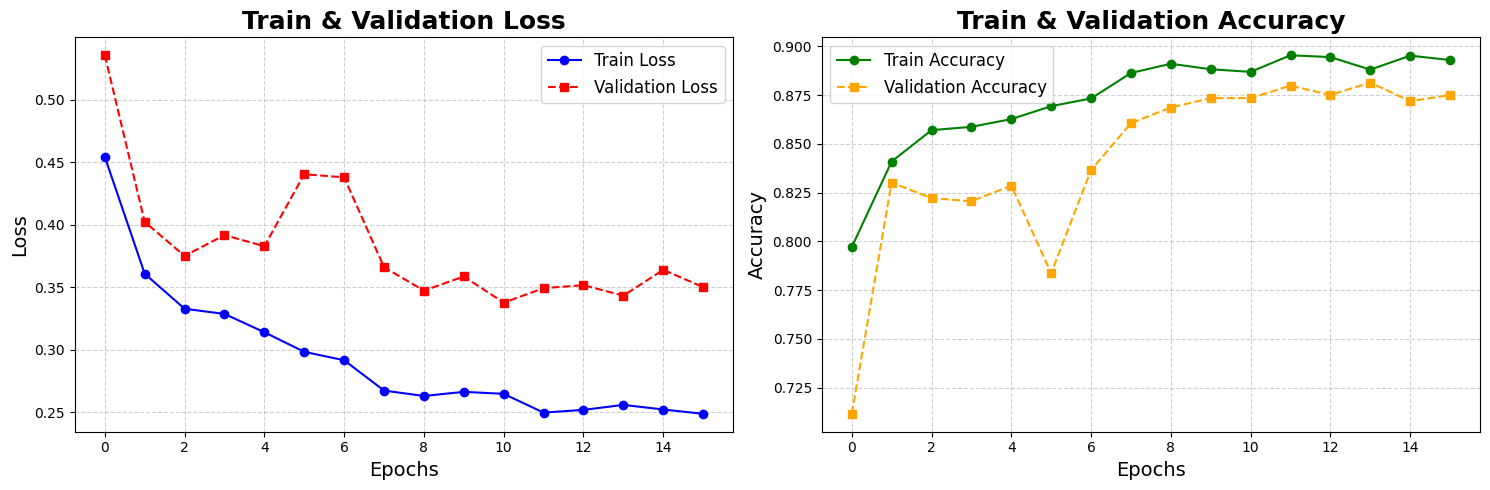

In [25]:
plt.figure(figsize=(15, 5))
# Loss plot
plt.subplot(1, 2, 1)
plt.plot(logs['train_loss'], label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(logs['val_loss'], label='Validation Loss', color='red', linestyle='--', marker='s')
plt.title('Train & Validation Loss', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(logs['train_acc'], label='Train Accuracy', color='green', linestyle='-', marker='o')
plt.plot(logs['val_acc'], label='Validation Accuracy', color='orange', linestyle='--', marker='s')
plt.title('Train & Validation Accuracy', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

